In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Not immediately usable with this dataset as files contain 24-bit data
from scipy.io import wavfile
from scipy.io.wavfile import read, write

import IPython.display as ipd
from IPython.display import Audio
from numpy.fft import fft, ifft
from glob import glob
import librosa as lr
import librosa.display
import os
from scipy import signal as sig
from tqdm import tqdm

# !pip install pydub
from pydub import AudioSegment

Reference: https://www.youtube.com/watch?v=vJ_WL9aYfNI

In [ ]:
demo_df = pd.read_csv('/content/drive/MyDrive/ICBHI/demographic_info.txt', 
                      delim_whitespace=True,
                      names=['Subject ID', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 
                             'Child Weight (kg)' , 'Child Height (cm)'], 
                      header=None)
demo_df.head()

,Subject ID,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [ ]:
diag_df = pd.read_csv('/content/drive/MyDrive/ICBHI/ICBHI_Challenge_diagnosis.txt', 
                      delimiter='\t',
                      names=['Subject ID', 'Diagnosis'], 
                      header=None)
diag_df.head()

,Subject ID,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
df =  demo_df.join(diag_df.set_index('Subject ID'), on = 'Subject ID', how = 'left')
df.head()

,Subject ID,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI


In [ ]:
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [ ]:
root = '/content/drive/MyDrive/ICBHI/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

# Number of annotation files
len(filenames)

920

In [ ]:
audiofiles = glob(root + '/*.wav')

# Number of audio files
len(audiofiles)

920

In [ ]:
# Extract file information and annotation information
def extract(filename, root):
    tokens = filename.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Subject ID', 'Recording Index', 'Chest Location','Acquisition Mode','Recording Equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, filename + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
# Split filename
def file_split(file):
  return file.split('_')

file_split('160_1b3_Lr_mc_AKGC417L')

['160', '1b3', 'Lr', 'mc', 'AKGC417L']

In [ ]:
# Information about each file, annotations from each file
information = []
annotations = []
for file in filenames:
    (info, anno) = extract(file, root)
    information.append(info)
    name_data = file_split(file)
    anno['Subject ID'] = name_data[0]
    anno['Mode'] = name_data[3]
    anno['Filename'] = file
    annotations.append(anno)

In [ ]:
rec_info = pd.concat(information, ignore_index=True)
rec_info.head()

,Subject ID,Recording Index,Chest Location,Acquisition Mode,Recording Equipment
0,160,1b3,Lr,mc,AKGC417L
1,160,1b3,Pr,mc,AKGC417L
2,160,1b3,Pl,mc,AKGC417L
3,160,1b3,Tc,mc,AKGC417L
4,160,1b4,Al,mc,AKGC417L


In [ ]:
anno_df = pd.concat(annotations, ignore_index=True)
anno_df.head()

,Start,End,Crackles,Wheezes,Subject ID,Mode,Filename
0,1.862,5.718,0,1,160,mc,160_1b3_Lr_mc_AKGC417L
1,5.718,9.725,0,1,160,mc,160_1b3_Lr_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Lr_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Lr_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Lr_mc_AKGC417L


In [ ]:
# Counts for each class
no_label = []
crackles_only = []
wheezes_only = []
both_symp = []
for file in filenames:
    data = anno_df.loc[anno_df['Filename'] == file]
    no_labels = len(data[(data['Crackles'] == 0) & (data['Wheezes'] == 0)].index)
    crackles = len(data[(data['Crackles'] == 1) & (data['Wheezes'] == 0)].index)
    wheezes = len(data[(data['Crackles'] == 0) & (data['Wheezes'] == 1)].index)
    both_symps = len(data[(data['Crackles'] == 1) & (data['Wheezes'] == 1)].index)
    no_label.append(no_labels)
    crackles_only.append(crackles)
    wheezes_only.append(wheezes)
    both_symp.append(both_symps)

In [ ]:
# Not as useful
label_df = pd.DataFrame(data = {'Filename':filenames, 'No Label':no_label, 'Crackles Only':crackles_only, 'Wheezes Only':wheezes_only, 'Crackles and Wheezes':both_symp})
label_df.head()

,Filename,No Label,Crackles Only,Wheezes Only,Crackles and Wheezes
0,160_1b3_Lr_mc_AKGC417L,1,0,4,0
1,160_1b3_Pr_mc_AKGC417L,0,1,0,4
2,160_1b3_Pl_mc_AKGC417L,1,0,2,2
3,160_1b3_Tc_mc_AKGC417L,2,0,3,0
4,160_1b4_Al_mc_AKGC417L,0,0,0,4


In [ ]:
# Totals for each label
label_df.sum()

Filename                160_1b3_Lr_mc_AKGC417L160_1b3_Pr_mc_AKGC417L16...
No Label                                                             3642
Crackles Only                                                        1864
Wheezes Only                                                          886
Crackles and Wheezes                                                  506
dtype: object

Longest cycle: 16.163
Shortest cycle: 0.20000000000000284
Average cycle: 2.7005090852420994
Fraction of samples less than 5 seconds:0.9660771238040011


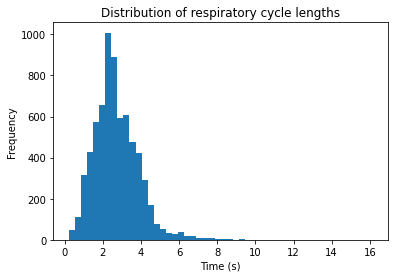

In [ ]:
# Calculate durations for each respiratory cycle
durations = []
for i in range(len(annotations)):
    current = annotations[i]
    duration = current['End'] - current['Start']
    durations.extend(duration)
    
durations = np.array(durations)

plt.hist(durations, bins = 50)
plt.title('Distribution of respiratory cycle lengths')
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
print('Longest cycle: {}'.format(max(durations)))
print('Shortest cycle: {}'.format(min(durations)))
print('Average cycle: {}'.format(np.sum(durations)/len(durations)))
threshold = 5
print('Fraction of samples less than {} seconds:{}'.format(threshold, np.sum(durations < threshold)/len(durations)))

In [ ]:
# Merge diag_df with anno_df on Subject ID
diag_df['Subject ID'] = diag_df['Subject ID'].astype('int32')
anno_df['Subject ID'] = anno_df['Subject ID'].astype('int32')
sub_anno_df = pd.merge(diag_df, anno_df, on='Subject ID')
sub_anno_df.head()

,Subject ID,Diagnosis,Start,End,Crackles,Wheezes,Mode,Filename
0,101,URTI,0.036,0.579,0,0,sc,101_1b1_Al_sc_Meditron
1,101,URTI,0.579,2.450,0,0,sc,101_1b1_Al_sc_Meditron
2,101,URTI,2.450,3.893,0,0,sc,101_1b1_Al_sc_Meditron
3,101,URTI,3.893,5.793,0,0,sc,101_1b1_Al_sc_Meditron
4,101,URTI,5.793,7.521,0,0,sc,101_1b1_Al_sc_Meditron


In [ ]:
# os.makedirs('preprocessed_data')
sub_anno_df.to_csv('preprocessed_data/annotated_subject_data.csv', index=False)

In [ ]:
# Extract audio filenames
audionames = [s.split('.')[0] for s in os.listdir(path = root) if '.wav' in s]

len(audionames)

920

In [ ]:
# Get waveforms
def signal_and_sr(filename, root):
    name = root + filename + '.wav'
    data, sr = lr.load(name, sr=22050) # Sampling rate at 22050 for consistency (typical for librosa but dataset contains more than one sr - 44100, 4000 and 10000)
    return (data, sr)

waveforms = {}
for audio in audionames:
    (signal, sr) = signal_and_sr(audio, root) # signal is an array with (sr * duration) values, sr is 22050
    waveforms[audio] = signal

In [ ]:
example = audionames[0]
ex_audio = audiofiles[0]

lr.display.waveplot(waveforms[example], sr=44100)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(ex_audio)

Output hidden; open in https://colab.research.google.com to view.

Time-frequency & time-signal analysis (Serbes, Sakar, Kahya & Aydin, 2012).

In [ ]:
# Get spectrums
magnitudes = {}
frequencies = {}
for file, signal in waveforms.items():
  fft = np.fft.fft(signal) # produces a numpy array with as many complex values as the total samples in the waveform
  magnitudes[file] = np.abs(fft) # determine the contribution of each frequency bin to the overall sound
  frequencies[file] = np.linspace(0, 22050, len(magnitudes[file]))

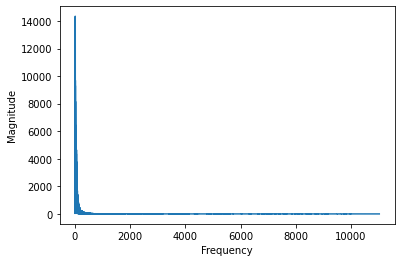

In [ ]:
plt.plot(frequencies[example][:int(len(frequencies[example])/2)], magnitudes[example][:int(len(frequencies[example])/2)])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

In [ ]:
# Get spectrograms (this uses all of the RAM...)
# n_fft = 2048 # window (number of samples per fft)
# hop_length = 512 # how large of a shift is performed to get to next fft

# stfts = {}
# spectrograms = {}
# log_specs = {}
# for file, signal in waveforms.items():
#   stfts[file] = lr.core.stft(signal, hop_length = hop_length, n_fft = n_fft)
#   spectrograms[file] = np.abs(stfts[file])
#   log_specs[file] = lr.amplitude_to_db(spectrograms[file])

In [ ]:
# Get spectrogram for one example
n_fft = 2048 # window (number of samples per fft)
hop_length = 512 # how large of a shift is performed to get to next fft

stft = lr.core.stft(waveforms[example], hop_length = hop_length, n_fft = n_fft)
spectrogram = np.abs(stft)
log_specs = lr.amplitude_to_db(spectrogram)

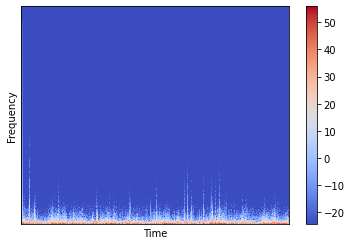

In [ ]:
lr.display.specshow(log_specs, sr=22050, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

Mel-frequency cepstral coefficients (Glangetas et al. 2021).

In [ ]:
# Get MFCCs
mfccs = {}
for file, signal in waveforms.items():
  mfccs[file] = lr.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

In [ ]:
lr.display.specshow(mfccs[example], sr=22050, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

Power spectral density (Icer & Gengec, 2014).

In [ ]:
# Compute PSD
psds = {} # shows strength of variations as a function of frequency
freqs = {}
for file, signal in waveforms.items():
  freqs[file], psds[file] = sig.welch(signal)

In [ ]:
plt.semilogx(freqs[example], psds[example])
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

Liftering

In [ ]:
# feature_dict = {}
# for file, signal in waveforms.items():
#   feature_dict[file] = {
#       'Signal': signal,
#       'Magnitude': magnitudes[file],
#       'Frequency': frequencies[file],
#       'STFT': stfts[file],
#       'Spectrogram': spectrograms[file],
#       'Log Spectrogram': log_specs[file],
#       'MFCC': mffcs[file]
#       'PSD': psds[file]
#   }

# feature_df = pd.DataFrame(feature_dict.items())
# feature_df.head()

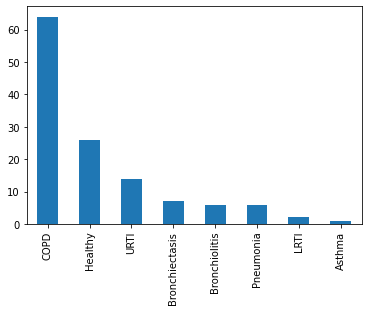

In [ ]:
# Class imbalance
diag_df['Diagnosis'].value_counts().plot(kind='bar');